In [1]:
%load_ext jupyter_black

## Note
I was unable to create an environment that supports both tensorflow-gpu and cudf to a dependency conflict with protobuff

# nvidia cuda


``` bash
nvidia-smi --query-gpu=timestamp,name,pci.bus_id,driver_version,pstate,pcie.link.gen.max,pcie.link.gen.current,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv
nvidia-smi --query-gpu=name,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv -l 5

nvidia-smi -q -g 0 -d UTILIZATION -l
==============NVSMI LOG==============

Timestamp                                 : Sat Aug 13 18:07:02 2022
Driver Version                            : 516.59
CUDA Version                              : 11.7

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Utilization
        Gpu                               : 1 %
        Memory                            : 1 %
        Encoder                           : 0 %
        Decoder                           : 0 %
    GPU Utilization Samples
        Duration                          : 98.31 sec
        Number of Samples                 : 99
        Max                               : 6 %
        Min                               : 0 %
        Avg                               : 0 %
    Memory Utilization Samples
        Duration                          : 98.31 sec
        Number of Samples                 : 99
        Max                               : 1 %
        Min                               : 0 %
        Avg                               : 0 %
    ENC Utilization Samples
        Duration                          : 98.31 sec
        Number of Samples                 : 99
        Max                               : 0 %
        Min                               : 0 %
        Avg                               : 0 %
    DEC Utilization Samples
        Duration                          : 98.31 sec
        Number of Samples                 : 99
        Max                               : 0 %
        Min                               : 0 %
        Avg                               : 0 %
```

In [2]:
import distributed

from dask_cuda import LocalCUDACluster


def close():
    """
    for convenience if a cluster/client is already running
    this should close them to prevent starting multiple clusters
    on the same port.
    """
    try:
        client.close(), cluster.close()
    except:
        ...


close()
cluster = LocalCUDACluster()
client = distributed.Client(cluster)

client

/opt/conda/envs/rapids/lib/python3.9/site-packages/dask_cuda/utils.py:244: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(
2022-09-09 01:12:43,466 - distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/griblib/notebooks/probsevere/dask-worker-space/worker-eboixout', purging
2022-09-09 01:12:43,467 - distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/griblib/notebooks/probsevere/dask-worker-space/worker-92p_go8w', purging
2022-09-09 01:12:43,467 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


[1662685963.844175] [808bedc85093:580  :0]  cuda_ipc_iface.c:145  UCX  ERROR nvmlDeviceGetHandleByIndex_v2(ordinal, &device) failed: Unknown Error


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 50.07 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39125,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 50.07 GiB
Comm: tcp://127.0.0.1:40121,Total threads: 1
Dashboard: http://127.0.0.1:38365/status,Memory: 50.07 GiB
Nanny: tcp://127.0.0.1:35717,


In [3]:
import os
from pathlib import Path

import pandas as pd
import dask.dataframe as dd
import cudf

# creating a Path object from the absolute path to our data folder
ps_data = Path.cwd().parents[1] / "data-bucket"
all_files = tuple(ps_data.rglob("*.pq"))
ps_data

PosixPath('/workspaces/griblib/data-bucket')

In [4]:
len(all_files)

1840

In [4]:
%%time
# reading with pure pandas and pyarrow
pd.concat((pd.read_parquet(file, engine="pyarrow") for file in all_files))

CPU times: user 9.68 s, sys: 2.79 s, total: 12.5 s
Wall time: 9.08 s


,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,FLASH_DENSITY,...,MOTION_SOUTH,PS,ID,VALIDTIME,MINX,MINY,MAXX,MAXY,X,Y
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
18,3116,1595,-4,45.799999,26,14.300000,0.04,0.36,0,0.00,...,-3.935000,9,26063,2022-04-03 19:54:35,-78.730003,25.240000,-78.660004,25.340000,-78.711250,25.295000
18,614,189,-23,24.000000,34,15.500000,0.39,1.12,2,0.16,...,-29.405001,2,26238,2022-04-03 23:10:41,-100.660004,32.369999,-100.570000,32.450001,-100.610001,32.404999
18,1342,351,-91,63.299999,106,15.100000,0.05,0.89,0,0.00,...,3.531000,8,25094,2022-04-03 03:32:38,-83.269997,25.209999,-83.199997,25.290001,-83.239998,25.245001
18,2860,1389,-2,43.000000,31,16.200001,0.10,0.77,0,0.00,...,-23.271000,9,26077,2022-04-03 20:06:36,-78.190002,25.400000,-78.110001,25.490000,-78.156250,25.445000
18,0,0,0,0.000000,167,17.799999,0.00,2.87,0,0.00,...,0.264000,0,25245,2022-04-03 06:12:37,-97.779999,36.430000,-97.650002,36.630001,-97.720001,36.529999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,1387,811,-27,57.599998,64,10.300000,0.00,0.55,0,0.00,...,11.488000,6,25158,2022-04-03 04:24:36,-82.250000,24.930000,-82.180000,25.000000,-82.221001,24.969999
17,2433,1577,-59,52.200001,26,20.100000,0.16,0.63,6,0.12,...,0.339000,18,24782,2022-04-03 00:34:39,-78.900002,27.320000,-78.790001,27.480000,-78.834999,27.410000
17,1623,853,-8,54.000000,35,7.500000,0.00,0.46,0,0.02,...,-0.803000,7,25211,2022-04-03 05:30:36,-81.820000,24.639999,-81.739998,24.700001,-81.781250,24.684999


In [6]:
%%time
# much faster to read into a dask dataframe
ddf: dd.DataFrame = dd.read_parquet(all_files)
ddf

CPU times: user 71 ms, sys: 807 µs, total: 71.8 ms
Wall time: 64.6 ms


,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,FLASH_DENSITY,MAXLLAZ,P98LLAZ,P98MLAZ,WETBULB_0C_HGT,PWAT,CAPE_M10M30,LJA,SIZE,MOTION_EAST,MOTION_SOUTH,PS,ID,VALIDTIME,MINX,MINY,MAXX,MAXY,X,Y
npartitions=1840,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,uint32,uint32,int32,float32,uint32,float32,float32,float32,uint32,float32,float32,float32,float32,float32,float32,uint32,float32,uint32,float32,float32,uint8,uint32,datetime64[ns],float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
%%time
# again, but the compute time to convert it back to a pandas native object is more expensive
ddf: dd.DataFrame = dd.read_parquet(all_files)
ddf.compute()

CPU times: user 5.55 s, sys: 207 ms, total: 5.75 s
Wall time: 14.2 s


,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,FLASH_DENSITY,...,MOTION_SOUTH,PS,ID,VALIDTIME,MINX,MINY,MAXX,MAXY,X,Y
0,1524,1270,0,51.400002,36,17.900000,0.92,2.08,36,1.25,...,6.203,88,136524,2022-03-01 00:00:29,-79.209999,30.120001,-79.070000,30.280001,-79.139999,30.200001
0,61,74,0,11.100000,225,46.000000,0.00,0.45,0,0.00,...,2.775,0,137200,2022-03-01 10:42:34,-122.099998,45.380001,-121.949997,45.509998,-122.023331,45.450001
0,74,76,0,12.200000,227,45.599998,0.00,0.45,0,0.00,...,-0.083,0,137200,2022-03-01 10:40:35,-122.169998,45.330002,-121.949997,45.500000,-122.055496,45.410000
0,990,642,0,32.299999,27,13.300000,0.10,0.70,0,0.00,...,-0.477,2,137196,2022-03-01 10:38:37,-78.800003,26.600000,-78.709999,26.709999,-78.756248,26.655001
0,990,642,0,32.299999,27,13.300000,0.11,0.72,0,0.00,...,38.986,2,137196,2022-03-01 10:36:32,-78.800003,26.600000,-78.709999,26.709999,-78.756248,26.655001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,1763,1683,0,47.900002,158,38.000000,0.04,0.64,0,0.01,...,-2.204,8,33465,2022-04-05 09:22:40,-93.080002,31.090000,-92.980003,31.180000,-93.025002,31.129999
192,1716,1618,-3,52.599998,157,33.000000,0.00,0.52,0,0.00,...,-11.537,6,33452,2022-04-05 09:20:41,-88.330002,30.930000,-88.209999,31.040001,-88.271248,30.990000
193,2295,1786,0,54.400002,113,35.599998,0.00,0.66,0,0.00,...,-13.324,7,33466,2022-04-05 09:22:40,-89.309998,30.540001,-89.239998,30.600000,-89.275002,30.570000
193,1878,1832,0,48.099998,149,37.599998,0.05,0.65,0,0.02,...,-5.853,11,33453,2022-04-05 09:20:41,-92.860001,30.830000,-92.800003,30.900000,-92.830002,30.865000


In [6]:
%%time
# the parquet files we're create using dask.dataframe
gdf: cudf.DataFrame = cudf.read_parquet(all_files)
df = gdf.to_pandas()
del gdf  # delete the dataframe from gpu memory after it has been loaded to gpu ram
df

CPU times: user 1.41 s, sys: 688 ms, total: 2.1 s
Wall time: 3.05 s


,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,FLASH_DENSITY,...,MOTION_SOUTH,PS,ID,VALIDTIME,MINX,MINY,MAXX,MAXY,X,Y
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
18,3116,1595,-4,45.799999,26,14.300000,0.04,0.36,0,0.00,...,-3.935000,9,26063,2022-04-03 19:54:35,-78.730003,25.240000,-78.660004,25.340000,-78.711250,25.295000
18,614,189,-23,24.000000,34,15.500000,0.39,1.12,2,0.16,...,-29.405001,2,26238,2022-04-03 23:10:41,-100.660004,32.369999,-100.570000,32.450001,-100.610001,32.404999
18,1342,351,-91,63.299999,106,15.100000,0.05,0.89,0,0.00,...,3.531000,8,25094,2022-04-03 03:32:38,-83.269997,25.209999,-83.199997,25.290001,-83.239998,25.245001
18,2860,1389,-2,43.000000,31,16.200001,0.10,0.77,0,0.00,...,-23.271000,9,26077,2022-04-03 20:06:36,-78.190002,25.400000,-78.110001,25.490000,-78.156250,25.445000
18,0,0,0,0.000000,167,17.799999,0.00,2.87,0,0.00,...,0.264000,0,25245,2022-04-03 06:12:37,-97.779999,36.430000,-97.650002,36.630001,-97.720001,36.529999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,1387,811,-27,57.599998,64,10.300000,0.00,0.55,0,0.00,...,11.488000,6,25158,2022-04-03 04:24:36,-82.250000,24.930000,-82.180000,25.000000,-82.221001,24.969999
17,2433,1577,-59,52.200001,26,20.100000,0.16,0.63,6,0.12,...,0.339000,18,24782,2022-04-03 00:34:39,-78.900002,27.320000,-78.790001,27.480000,-78.834999,27.410000
17,1623,853,-8,54.000000,35,7.500000,0.00,0.46,0,0.02,...,-0.803000,7,25211,2022-04-03 05:30:36,-81.820000,24.639999,-81.739998,24.700001,-81.781250,24.684999


In [7]:
%%time
from pathlib import Path
from contextlib import contextmanager
from dataclasses import dataclass, field
from typing import Callable, Iterable, Generator, Literal, Mapping

try:
    from cudf import DataFrame, read_parquet
    import cupy as cp
except ModuleNotFoundError:
    from cudf import DataFrame, read_parquet
    import numpy as cp

import numpy as np
import nvector as nv
from numpy.typing import NDArray


class CUDArray(NDArray):
    def get(self) -> np.ndarray:
        ...


class CudaDataFrame(pd.DataFrame):
    def to_pandas(self) -> pd.DataFrame:
        ...

    @property
    def loc(self) -> Mapping[any, "CudaDataFrame"]:
        ...

    @property
    def values(self) -> CUDArray:
        ...


class CaseInsensiveSTR(str):
    def __eq__(self, __other: str):
        return self.casefold() == __other.casefold()


@contextmanager
def parquet_session(
    files: Iterable[Path], *, engine: str = "cudf", index: list[str] = ["VALIDTIME", "ID"]
) -> Generator[CudaDataFrame, None, None]:
    """

    context manager to remove the dataframe from the gpu memory
    """
    try:
        gdf = read_parquet(files, engine=engine).set_index(index).sort_index()
        yield gdf
    finally:
        del gdf


def enforce_literal(exc: Exception = Exception, case_insensitive: bool = True):
    """
    decorator function to inforce Litteral type hint annotations on keyword arguments
    """

    def __generate(_func_kwargs: dict[str, any]):
        for k, v in _func_kwargs.items():
            if v.__class__.__name__ == "_LiteralGenericAlias":
                yield k, tuple(
                    _v if case_insensitive and not isinstance(_v, str) else CaseInsensiveSTR(_v) for _v in v.__args__
                )

    def wraps(func: Callable):
        enforce = tuple(__generate(func.__annotations__))

        def inner(*args, **kwargs):
            for k, v in enforce:
                if not kwargs[k] in v:
                    raise exc("Literal Type Enforcement")
            return func(*args, **kwargs)

        return inner

    return wraps


@dataclass(frozen=True)
class BoundingBox:
    """
    Nominatim API
    Nominatim API returns a boundingbox property of the form:

    south Latitude, north Latitude, west Longitude, east Longitude
    For example, Greater London in JSON format:

    "boundingbox":["51.2867602","51.6918741","-0.5103751","0.3340155"]


    ```
    bbox = BoundingBox(20.005, 54.995, -129.995, -60.005, shape=(7000, 2500))
    with gpu_session(files) as gdf:
        gdf["X"] = bbox.fit_array(gdf["X"].values, axis=0)
        gdf["Y"] = bbox.fit_array(gdf["Y"].values, axis=1)
    ```
    """

    south: float
    north: float
    west: float
    east: float
    shape: tuple[int, int]
    frame_e: nv.FrameE = field(repr=False, default=nv.FrameE(name="WGS84"))

    @property
    def latitudes(self) -> CUDArray:
        _, y_num = self.shape
        return cp.linspace(
            self.south,  # south lat
            self.north,  # north lat
            y_num,  # points in between
            dtype=cp.float32,
        )

    @property
    def longitudes(self) -> CUDArray:
        x_num, _ = self.shape
        return cp.linspace(
            self.west,  # west lon
            self.east,  # east lon
            x_num,  # points in between
            dtype=cp.float32,
        )

    @property
    def matrix(self) -> CUDArray:
        return cp.array(cp.meshgrid(self.latitudes, self.longitudes), dtype=cp.float32).T

    @property
    def latrange(self) -> tuple[float, float]:
        return self.north, self.south

    @property
    def lonrange(self) -> tuple[float, float]:
        return self.west, self.east

    @property
    def y_dist(self) -> CUDArray:

        return self.__calculate_step(
            self.longitudes,
            self.latrange,
            len(self.latitudes),
        )

    @property
    def x_dist(self) -> CUDArray:

        return self.__calculate_step(
            self.latitudes,
            self.lonrange,
            len(self.longitudes),
        )

    def __calculate_step(self, target: CUDArray, step_range: tuple[float, float], count: int) -> CUDArray:
        """
        calculates the geometric distance within the bounding box

        ```
        array_west, array_east = np.array(list([bbox.lonrange]) * len(bbox.lattitudes)).T

        ecef_west = bbox.frame_e.GeoPoint(bbox.lattitudes.get(), array_west, degrees=True).to_ecef_vector()

        ecef_east = bbox.frame_e.GeoPoint(bbox.lattitudes.get(), array_east, degrees=True).to_ecef_vector()

        ecef_delta = ecef_east - ecef_west

        return cp.array(ecef_delta.length) / len(bbox.longitudes)
        ```
        """

        array_a, array_b = np.array([[step_range]] * len(target)).T

        ecef_a = self.frame_e.GeoPoint(target.get(), array_a, degrees=True).to_ecef_vector()

        ecef_b = self.frame_e.GeoPoint(target.get(), array_b, degrees=True).to_ecef_vector()

        ecef_delta = ecef_a - ecef_b

        return cp.array(ecef_delta.length) / count

    def delta_a2b(self, array_a: CUDArray, array_b: CUDArray, axis: Literal["X", "Y"]) -> CUDArray:
        zeros = np.zeros(len(array_a))
        if axis == "X":
            lat_a, lat_b = array_a.get(), array_b.get()
            lon_a, lon_b = zeros, zeros
        elif axis == "Y":
            lat_a, lat_b = zeros, zeros
            lon_a, lon_b = array_a.get(), array_b.get()
        else:
            raise Exception

        ecef_a = self.frame_e.GeoPoint(lat_a, lon_a, degrees=True).to_ecef_vector()

        ecef_b = self.frame_e.GeoPoint(lat_b, lon_b, degrees=True).to_ecef_vector()

        return cp.array((ecef_a - ecef_b).length)

    @enforce_literal(KeyError)
    def fit_array(self, values: CUDArray, axis: Literal["X", "Y"]) -> tuple[CUDArray, CUDArray]:
        """
        determines the nearest grid line in a given axis for an array
        calculates the distance along that axis to the nearest line
        """
        if axis not in ("X", "Y"):
            raise Exception

        target = self.longitudes if axis == "X" else self.latitudes

        min_diff = self.diffmin(target, values[:, cp.newaxis])

        near_line = target[min_diff]

        next_line = target[min_diff + 1]

        return near_line, self.delta_a2b(near_line, next_line, axis=axis)

    def diffmin(self, target: CUDArray, values: CUDArray) -> CUDArray:
        """
        determines the nearest grid line in a given axis for an array
        calculates the distance along that axis to the nearest line
        """
        return cp.argmin(abs(target - values), axis=1)

    @property
    def extent(self):
        return [self.west, self.east, self.south, self.north]


if __name__ == "__main__":
    south, north, west, east = 20.005, 54.995, -129.995, -60.005
    shape = (7000, 2500)
    bbox = BoundingBox(south, west, north, east, shape=shape)
    a = cp.array([-90])

    bbox.fit_array(a, axis="Y")

CPU times: user 1.7 s, sys: 20.6 ms, total: 1.72 s
Wall time: 1.83 s


In [8]:
@enforce_literal(FileNotFoundError)
def my_func(*, val: Literal["A", "B"] = ...):
    ...


try:
    my_func(val="C")
except FileNotFoundError:
    print("Literaly enforced")

Literaly enforced


In [9]:
%%time
PS_THRESH = 5
s, n, w, e = 24.30, 40, -103.17, -74.96
shape = np.array([6500, 3250]) // 2
se_conus = BoundingBox(s, n, w, e, shape=tuple(shape))
import textwrap


def echo(tripq: str):
    return print(textwrap.dedent(tripq))


def open_and_filter() -> pd.DataFrame:
    with parquet_session(all_files) as gdf:
        echo(
            f"""\
            PRE MASK:
            total values: {gdf.size}
            total storms: {len(gdf.index.get_level_values('ID').unique())}
        """
        )
        # bounds validation, going to shrink the dataset into a smaller one
        x, y = (gdf[dim] for dim in ("X", "Y"))
        x_mask = (x > se_conus.west) & (x < se_conus.east)
        y_mask = (y > se_conus.south) & (y < se_conus.north)
        # grouping by the STORM ID and to call the aggregate method to get thw
        # max value for a given storm
        ps = gdf["PS"].groupby(level="ID").agg("max")
        # masking the index where the ID is in the met condition
        ps_mask = gdf.index.get_level_values("ID").isin(ps.index[ps > PS_THRESH])
        # index the dataframe with the the met conditions
        gdf = gdf.loc[x_mask & y_mask & ps_mask]
        # XXX POST MASK XXX
        echo(
            f"""\
            POST MASK:
            total values: {gdf.size}
            total storms: {len(gdf.index.get_level_values('ID').unique())}
            """
        )
        # XXX FITTING INTO GRID XXX
        echo(
            f"""\
            PRE FIT:
            unique x: {len(gdf['X'].unique())}
            unique y: {len(gdf['Y'].unique())}
            """
        )
        x, step_x = se_conus.fit_array(gdf["X"].values, axis="X")
        y, step_y = se_conus.fit_array(gdf["Y"].values, axis="Y")
        gdf["X"] = x
        gdf["STEPX"] = step_x
        gdf["Y"] = y
        gdf["STEPY"] = step_y
        del x, step_x, y, step_y

        echo(
            f"""\
            POST FIT:
            unique x: {len(gdf['X'].unique())}
            unique y: {len(gdf['Y'].unique())}
            """
        )
        return gdf.to_pandas()


df = open_and_filter()

PRE MASK:
total values: 24429411
total storms: 125679

POST MASK:
total values: 8148114
total storms: 25703

PRE FIT:
unique x: 77143
unique y: 3139

POST FIT:
unique x: 3205
unique y: 1623

CPU times: user 2.43 s, sys: 4.29 s, total: 6.72 s
Wall time: 2.7 s


In [10]:
df

MUCAPE  MLCAPE  MLCIN    EBSHEAR  SRH01KM  \
VALIDTIME           ID                                                  
2022-03-01 00:00:29 136524    1524    1270      0  51.400002       36   
                    136658     612     267    -27  41.000000       65   
                    136670    1330    1038     -2  38.700001       42   
                    136671    1708    1155      0  49.299999       29   
                    136681    1880    1584   -999  44.599998       36   
...                            ...     ...    ...        ...      ...   
2022-04-05 23:58:39 41246     2512    1656    -34  61.799999      147   
                    41247     1861    1494    -30  56.200001       84   
                    41250       50      29    -34  20.299999       78   
                    41251       29       0      0  15.200000      212   
                    41253     2300    1070    -26  45.900002       33   

                            MEANWIND_1-3kmAGL  MESH  VIL_DENSITY  FLASH_RATE  \
VALIDTIME           ID                                                         
2022-03-01 00:00:29 136524          17.900000  0.92         2.08          36   
                    136658           3.200000  0.08         1.32           0   
                    136670          19.200001  0.14         0.81           0   
                    136671          16.900000  0.33         1.00           1   
                    136681          18.000000  0.19         0.43           5   
...                                       ...   ...          ...         ...   
2022-04-05 23:58:39 41246           39.299999  0.00         0.41           0   
                    41247           31.500000  0.03         1.00           0   
                    41250           17.100000  0.00         0.32           0   
                    41251           26.100000  0.00         0.28           0   
                    41253           13.400000  0.00         0.81           1   

                            FLASH_DENSITY  ...  MOTION_SOUTH  PS       MINX  \
VALIDTIME           ID                     ...                                
2022-03-01 00:00:29 136524           1.25  ...         6.203  88 -79.209999   
                    136658           0.00  ...         6.624   3 -80.489998   
                    136670           0.00  ...         4.696   5 -79.709999   
                    136671           0.03  ...         3.922  19 -78.180000   
                    136681           0.43  ...         4.665  11 -78.190002   
...                                   ...  ...           ...  ..        ...   
2022-04-05 23:58:39 41246            0.00  ...        -6.776   7 -79.500000   
                    41247            0.01  ...        -6.776   9 -80.650002   
                    41250            0.00  ...        -9.074   0 -80.190002   
                    41251            0.00  ...        -9.189   0 -81.760002   
                    41253            0.03  ...        -0.069   6 -98.150002   

                                 MINY       MAXX       MAXY          X  \
VALIDTIME           ID                                                   
2022-03-01 00:00:29 136524  30.120001 -79.070000  30.280001 -79.136368   
                    136658  30.340000 -80.430000  30.400000 -80.464813   
                    136670  29.650000 -79.599998  29.780001 -79.648643   
                    136671  28.320000 -78.059998  28.469999 -78.120491   
                    136681  29.730000 -78.129997  29.799999 -78.155220   
...                               ...        ...        ...        ...   
2022-04-05 23:58:39 41246   30.680000 -79.440002  30.730000 -79.466309   
                    41247   29.139999 -80.279999  29.320000 -80.404037   
                    41250   39.930000 -80.129997  39.990002 -80.160919   
                    41251   38.470001 -81.690002  38.549999 -81.723801   
                    41253   28.469999 -98.000000  28.660000 -98.081955   

                                    Y       ST

In [13]:
%%time


def localize(files: Iterable[Path], bbox: BoundingBox, ps_thresh: int = 0) -> pd.DataFrame:

    with parquet_session(files) as gdf:
        # bounds validation, going to shrink the dataset into a smaller one
        x, y = (gdf[dim] for dim in ("X", "Y"))
        x_mask = (x > bbox.west) & (x < bbox.east)
        y_mask = (y > bbox.south) & (y < bbox.north)
        # grouping by the STORM ID and to call the aggregate method to get thw
        # max value for a given storm
        ps = gdf["PS"].groupby(level="ID").agg("max")
        # masking the index where the ID is in the met condition
        ps_mask = gdf.index.get_level_values("ID").isin(ps.index[ps > ps_thresh])
        # index the dataframe with the the met conditions
        gdf = gdf.loc[x_mask & y_mask & ps_mask]
        x, step_x = bbox.fit_array(gdf["X"].values, axis="X")
        y, step_y = bbox.fit_array(gdf["Y"].values, axis="Y")
        gdf["X"] = x
        gdf["STEPX"] = step_x
        gdf["Y"] = y
        gdf["STEPY"] = step_y
        del x, y, step_x, step_y

        return gdf.to_pandas()


def main():
    s, n, w, e = 25.0, 30.0, -90.0, -75.0
    shape = np.array([7000, 2500]) // 4
    bbox = BoundingBox(s, n, w, e, shape=tuple(shape))
    return localize(all_files, bbox)


if __name__ == "__main__":
    df = main()
df[["STEPX", "STEPY"]]

CPU times: user 1.18 s, sys: 2.71 s, total: 3.89 s
Wall time: 1.49 s


STEPX       STEPY
VALIDTIME           ID                            
2022-03-01 00:00:29 136565  957.995163  892.038547
                    136648  957.883598  892.006079
                    136662  957.996106  892.173869
                    136670  957.059449  891.891846
                    136671  956.966311  892.019580
...                                ...         ...
2022-04-05 23:58:39 41212   957.246745  891.999502
                    41230   957.937083  892.268961
                    41231   957.838548  891.799929
                    41232   958.068741  892.223051
                    41247   957.147518  892.021182

[161715 rows x 2 columns]

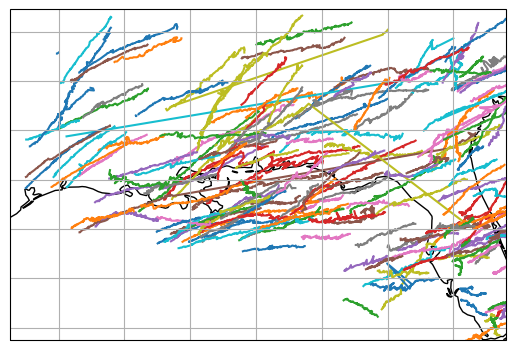

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

idx: slice = pd.IndexSlice
s, n, w, e = 25.0, 35.0, -95.0, -80.0
shape = np.array([7000, 2500]) // 4
bbox = BoundingBox(s, n, w, e, shape=tuple(shape))
df = localize(all_files, bbox)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(np.array(bbox.extent) * 1.005)
ax.coastlines(resolution="50m")
ax.gridlines()

mask = df.index.get_level_values("ID").value_counts() > 90

xy = df.loc[idx[:, mask[mask].index], ["X", "Y"]].unstack("ID")

ax.plot(xy["X"], xy["Y"], transform=ccrs.PlateCarree())

In [ ]:
%%time
def assert_bbox(south:float, north:float, west:float, east:float,*,shape:tuple[7000,2500] )->BoundingBox:
    bbox = BoundingBox(south, north, west, east, shape=shape)
    assert (
        (bbox.latitudes.min() == south)
        & (bbox.latitudes.max() == north)
        & (bbox.longitudes.min() == west)
        & (bbox.longitudes.max() == east)
    )
    assert shape == (*bbox.y_dist.shape, *bbox.x_dist.shape)
    assert cp.array(cp.meshgrid(bbox.x_dist, bbox.y_dist)).T.shape == bbox.matrix.shape
    return bbox

def fit2grid(values:CUDArray,target:CUDArray, )->CUDArray:
    return target[cp.argmin(abs(target - values[:, np.newaxis]), axis=1)]



CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs
